<a href="https://colab.research.google.com/github/alex-smith-uwec/CS491/blob/main/word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

import nltk
nltk.download('punkt')
nltk.download('stopwords')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
my_path="/content/drive/MyDrive/CS491/Data/US_Inaugural_Addresses"

In [5]:
# Define a function to preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = word_tokenize(text)
    # Remove punctuation and stop words
    tokens = [word for word in tokens if word not in string.punctuation and word not in stopwords.words('english')]
    return tokens



In [8]:
# Assuming all your text files are in the 'inauguration_speeches' directory
directory = my_path
all_files = os.listdir(directory)


In [ ]:
sentences = [] # This will store all sentences needed for training

for filename in all_files:
    filepath = os.path.join(directory, filename)
    with open(filepath, 'r', encoding='utf-8') as file:
        text = file.read()
        # Preprocess and tokenize the text
        tokens = preprocess_text(text)
        sentences.append(tokens)

In [ ]:
# sentences[5]

In [60]:
##How many CPU cores are availabe in Colab?
!cat /proc/cpuinfo | grep processor | wc -l

2


In [81]:
# Train a Word2Vec model
model = Word2Vec(sentences, vector_size=200, window=5, min_count=1, workers=4)
model.save("presidential_speeches_word2vec.model")




In [82]:
len(model.wv.index_to_key)

9509

In [83]:
# After training, you can use the model to find similar words, etc.
model.wv.most_similar('woman',topn=3)

[('suffrage', 0.9867146611213684),
 ('seek', 0.9866819381713867),
 ('entire', 0.9865373373031616)]

In [84]:
# Example words
word1 = "woman"
word2 = "vote"
word3="liberty"

# Get the vector for each word
vector1 = model.wv[word1]
vector2 = model.wv[word2]
vector3=model.wv[word3]

# Add the vectors
added_vector = vector1 + vector2+vector3

# You can now use the resulting vector to find similar words, for example
similar_words = model.wv.similar_by_vector(added_vector,topn=5)

print(similar_words)


[('liberty', 0.9999437928199768), ('may', 0.9998909831047058), ('nation', 0.9998887777328491), ('people', 0.9998869895935059), ('country', 0.9998859763145447)]


In [86]:
# Extract a slice of word vectors
words = list(model.wv.index_to_key[100:120])  # Adjust the slice for the number of words you want
word_vectors = [model.wv[word] for word in words]


In [87]:
len(words)

20

# Plotting word embedding

In [88]:
import numpy as np
from sklearn.decomposition import PCA

# Convert word vectors into a 2D array of shape (number_of_words, dimensions_of_vectors)
word_vectors_matrix = np.array(word_vectors)

# Initialize and fit PCA
pca = PCA(n_components=2)
word_vectors_2d = pca.fit_transform(word_vectors_matrix)


In [89]:
##Filtering out points that have outlier coordinates, in order prevent plot scaling problems

# Assuming word_vectors is a list of [x, y] points
word_vectors = np.array(word_vectors)

# Calculate Q1, Q3, and IQR for x and y coordinates
Q1_x, Q3_x = np.percentile(word_vectors[:, 0], [25, 75])
IQR_x = Q3_x - Q1_x
Q1_y, Q3_y = np.percentile(word_vectors[:, 1], [25, 75])
IQR_y = Q3_y - Q1_y

# Define bounds for outliers
lower_bound_x = Q1_x - 1.5 * IQR_x
upper_bound_x = Q3_x + 1.5 * IQR_x
lower_bound_y = Q1_y - 1.5 * IQR_y
upper_bound_y = Q3_y + 1.5 * IQR_y

# Filter out outliers
filtered_vectors = [vec for vec in word_vectors if (
    lower_bound_x <= vec[0] <= upper_bound_x and
    lower_bound_y <= vec[1] <= upper_bound_y
)]

# If you need to filter the corresponding words as well:
filtered_words = [word for vec, word in zip(word_vectors, words) if (
    lower_bound_x <= vec[0] <= upper_bound_x and
    lower_bound_y <= vec[1] <= upper_bound_y
)]


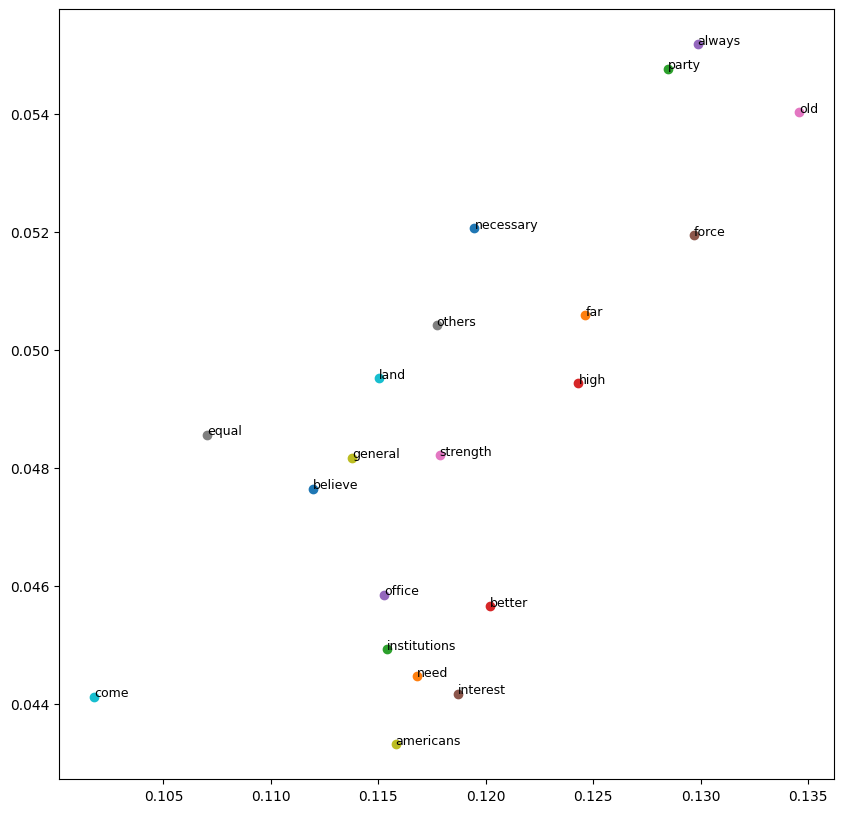

In [91]:
import matplotlib.pyplot as plt


# Ensure filtered_vectors is a numpy array
filtered_vectors = np.array(filtered_vectors)

plt.figure(figsize=(10, 10))

# Iterate over both words and vectors
for vec, word in zip(filtered_vectors, filtered_words):
    plt.scatter(vec[0], vec[1])
    plt.text(vec[0]+0.00, vec[1]+0.00, word, fontsize=9)


plt.show()



# Doc to Vec

In [29]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


tagged_documents = []  # This will store all tagged documents

def process_filename(filename):
    # Example: Remove file extension
    return filename.rsplit('.', 1)[0]

for filename in all_files:
    filepath = os.path.join(directory, filename)
    with open(filepath, 'r', encoding='utf-8') as file:
        text = file.read()
        tokens = preprocess_text(text)
        # Use the processed filename as the tag
        tag = process_filename(filename)
        tagged_documents.append(TaggedDocument(words=tokens, tags=[tag]))



In [30]:
len(tagged_documents)

59

In [63]:
# Train a Doc2Vec model
model = Doc2Vec(tagged_documents, vector_size=40, window=10, min_count=5, workers=4)
model.save("presidential_speeches_doc2vec.model")

# After training, you can use the model to infer vector for a new document or find similar documents
# Example: model.dv.most_similar(str(document_id))

In [64]:
list_of_document_ids = list(model.dv.key_to_index.keys())
sorted(list_of_document_ids)

['01_washington_1789',
 '02_washington_1793',
 '03_adams_john_1797',
 '04_jefferson_1801',
 '05_jefferson_1805',
 '06_madison_1809',
 '07_madison_1813',
 '08_monroe_1817',
 '09_monroe_1821',
 '10_adams_john_quincy_1825',
 '11_jackson_1829',
 '12_jackson_1833',
 '13_van_buren_1837',
 '14_harrison_1841',
 '15_polk_1845',
 '16_taylor_1849',
 '17_pierce_1853',
 '18_buchanan_1857',
 '19_lincoln_1861',
 '20_lincoln_1865',
 '21_grant_1869',
 '22_grant_1873',
 '23_hayes_1877',
 '24_garfield_1881',
 '25_cleveland_1885',
 '26_harrison_1889',
 '27_cleveland_1893',
 '28_mckinley_1897',
 '29_mckinley_1901',
 '30_roosevelt_theodore_1905',
 '31_taft_1909',
 '32_wilson_1913',
 '33_wilson_1917',
 '34_harding_1921',
 '35_coolidge_1925',
 '36_hoover_1929',
 '37_roosevelt_franklin_1933',
 '38_roosevelt_franklin_1937',
 '39_roosevelt_franklin_1941',
 '40_roosevelt_franklin_1945',
 '41_truman_1949',
 '42_eisenhower_1953',
 '43_eisenhower_1957',
 '44_kennedy_1961',
 '45_johnson_1965',
 '46_nixon_1969',
 '47_

In [65]:
model.dv.most_similar('35_coolidge_1925',topn=40)

[('23_hayes_1877', 0.9966657757759094),
 ('10_adams_john_quincy_1825', 0.9960194230079651),
 ('13_van_buren_1837', 0.9958868622779846),
 ('06_madison_1809', 0.9958724975585938),
 ('37_roosevelt_franklin_1933', 0.9956914186477661),
 ('27_cleveland_1893', 0.9956031441688538),
 ('26_harrison_1889', 0.9952513575553894),
 ('05_jefferson_1805', 0.9949816465377808),
 ('17_pierce_1853', 0.9949281215667725),
 ('11_jackson_1829', 0.9947870969772339),
 ('03_adams_john_1797', 0.9947158694267273),
 ('25_cleveland_1885', 0.9942325949668884),
 ('07_madison_1813', 0.9942099452018738),
 ('21_grant_1869', 0.9939588904380798),
 ('01_washington_1789', 0.9939163327217102),
 ('22_grant_1873', 0.9937052726745605),
 ('31_taft_1909', 0.993454098701477),
 ('16_taylor_1849', 0.9932552576065063),
 ('28_mckinley_1897', 0.9931862950325012),
 ('12_jackson_1833', 0.9925073385238647),
 ('36_hoover_1929', 0.9924031496047974),
 ('24_garfield_1881', 0.9914904832839966),
 ('29_mckinley_1901', 0.990878164768219),
 ('20_lin